# Notebook to generate psychometrics plot given sessions & conditions

In [4]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

import datajoint as dj
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches

from matplotlib import cm
from u19_pipeline import utility
from inspect import getmembers, isfunction


Local configuration file found !!, no need to run the configuration (unless configuration has changed)


### Datajoint configuration and Connection to DB

In [9]:
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
behavior    = dj.create_virtual_module('acquisition', 'u19_behavior')
subject     = dj.create_virtual_module('acquisition', 'u19_subject')
recording     = dj.create_virtual_module('recording', 'u19_recording')

key = subject.Subject() & "user_id = 'ms81'";
su = pd.DataFrame((recording.Recording.BehaviorSession * behavior.TowersBlock & key & "level = 11" & "block_performance>0.6").fetch(as_dict=True, order_by='block_performance DESC'))
su


,recording_id,subject_fullname,session_date,session_number,block,task,main_level,level,set_id,n_trials,first_trial,block_duration,block_start_time,reward_mil,reward_scale,easy_block,block_performance
0,36,ms81_M005,2021-05-05,0,5,Towers,11,11,1,20,227,556.684,2021-05-05 16:31:00,0.1512,2,0,0.900000
1,36,ms81_M005,2021-05-05,0,3,Towers,11,11,1,195,22,4061.750,2021-05-05 15:19:00,0.8792,1,0,0.800000
2,37,ms81_M005,2021-05-08,0,2,Towers,11,11,1,173,18,4248.050,2021-05-08 15:13:00,0.7560,1,0,0.768786
3,35,ms81_M004,2021-05-08,0,2,Towers,11,11,1,179,22,3969.660,2021-05-08 12:14:00,0.7784,1,0,0.765363
4,33,ms81_M004,2021-05-06,0,2,Towers,11,11,1,94,19,2275.680,2021-05-06 14:18:00,0.3752,1,0,0.712766
5,30,ms81_M005,2021-05-06,0,4,Towers,11,11,1,40,153,894.032,2021-05-06 17:59:00,0.2352,2,0,0.700000
6,34,ms81_M004,2021-05-07,0,2,Towers,11,11,1,47,15,1424.080,2021-05-07 13:39:00,0.1792,1,0,0.680851
7,31,ms81_M003,2021-05-07,0,4,Towers,11,11,1,94,65,2052.960,2021-05-07 10:43:00,0.3528,1,0,0.670213
8,40,ms81_M011,2021-11-20,0,8,Towers,11,11,1,61,161,1006.330,2021-11-20 16:37:00,0.2248,1,0,0.655738
9,73,ms81_M017,2022-06-10,0,2,Towers,11,11,1,52,11,862.738,2022-06-10 08:58:00,0.1904,1,0,0.653846


## Filter params

In [107]:

## Filter rigs
filter_rigs = True
rigs = ['165I-Rig1-T',
        '165I-Rig2-T',
        '165I-Rig3-T',
        '165I-Rig4-T',
        '165A-Rig5-T',
        '165A-Rig6-T',
        '165A-Rig7-T',
        '165A-Rig8-T', 
        '170b-Imaging0642',
        '185f-rig1',
        '188-Rig1',
        '188-Rig2',
        'BezosMeso',
        'C42-Bay2-Rig1-I']
rigs_label = ', '.join(f'"{w}"' for w in rigs)
rigs_query = 'session_location in (' + rigs_label + ')'

#Filter Dates
filter_dates = True
dates        = ['2016-01-01', '2022-03-01']
date_label   = ' and '.join(f'"{w}"' for w in dates)
date_query   = 'session_date between ' + date_label 

#Filter users
filter_user = True
users = ['sbolkan', 'jounhong']
users = ['subject_fullname like "' + x + '%"' for x in users]
user_query = ' or '.join(f'{w}' for w in users) 


#Min sessions to be a "real" subject
min_sessions = 15


### Create query based on filter params

In [108]:
query = []
if filter_rigs:
    query.append(rigs_query)
    
if filter_dates:
    query.append(date_query)
    
if filter_user:
    query.append(user_query)
    
# Filter by all conditions selected
session_table_filtered = acquisition.Session
for filter_key in query:
    session_table_filtered = session_table_filtered & filter_key
    
session_df = pd.DataFrame(session_table_filtered.fetch(as_dict=True))
session_df

,subject_fullname,session_date,session_number,session_start_time,session_end_time,session_location,task,level,set_id,stimulus_bank,stimulus_commit,session_performance,num_trials,num_trials_try,session_narrative,session_protocol,session_code_version,is_bad_session,session_comments
0,jounhong_CaMKIIa_tetO_23,2021-07-17,0,2021-07-17 08:00:00,2021-07-17 08:31:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,bd0170b13b2c80cdf7aafcc46524753c12798cf3,41.2698,63,[[63.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,
1,jounhong_CaMKIIa_tetO_23,2021-07-18,0,2021-07-18 07:54:00,2021-07-18 08:40:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,bd0170b13b2c80cdf7aafcc46524753c12798cf3,54.2056,107,[[107.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,
2,jounhong_CaMKIIa_tetO_23,2021-07-19,0,2021-07-19 11:02:00,2021-07-19 12:03:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,bd0170b13b2c80cdf7aafcc46524753c12798cf3,46.0396,202,[[202.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,
3,jounhong_CaMKIIa_tetO_23,2021-07-20,0,2021-07-20 12:20:00,2021-07-20 13:21:00,165A-Rig5-T,Towers,4,1,C:/Experiments/ViRMEn/experiments/protocols/st...,bd0170b13b2c80cdf7aafcc46524753c12798cf3,83.0040,253,[[253.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,
4,jounhong_CaMKIIa_tetO_23,2021-07-21,0,2021-07-21 13:06:00,2021-07-21 14:10:00,165A-Rig5-T,Towers,4,1,C:/Experiments/ViRMEn/experiments/protocols/st...,bd0170b13b2c80cdf7aafcc46524753c12798cf3,95.7265,234,[[234.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,sbolkan_test,2021-08-18,0,2021-08-18 09:47:00,2021-08-18 09:53:00,170b-Imaging0642,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,93abc7540a402d201e73a64e5c27027aa27f4b7c,33.3333,3,"[[2.0, 3.0]]",,poisson_patchesAndPuff_laserTTL.m poisson_bloc...,"[[2.1, 4.0]]",0,
3656,sbolkan_test,2021-08-19,0,2021-08-19 08:50:00,2021-08-19 08:50:00,170b-Imaging0642,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,93abc7540a402d201e73a64e5c27027aa27f4b7c,50.0000,2,[[2.0]],,poisson_patchesAndPuff_laserTTL.m poisson_bloc...,"[[2.1, 4.0]]",0,
3657,sbolkan_test,2021-08-20,0,2021-08-20 09:29:00,2021-08-20 09:30:00,170b-Imaging0642,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,93abc7540a402d201e73a64e5c27027aa27f4b7c,66.6667,3,[[3.0]],,poisson_patchesAndPuff_laserTTL.m poisson_bloc...,"[[2.1, 4.0]]",0,
3658,sbolkan_test,2021-08-23,0,2021-08-23 09:34:00,2021-08-23 09:35:00,170b-Imaging0642,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,93abc7540a402d201e73a64e5c27027aa27f4b7c,60.0000,5,[[5.0]],,poisson_patchesAndPuff_laserTTL.m poisson_bloc...,"[[2.1, 4.0]]",0,


## Protocols used

In [113]:

protocol_df = session_df.groupby('session_protocol').agg({'subject_fullname': [('num_sessions', 'count'), ('num_subjects', 'nunique')]})
protocol_df.columns = protocol_df.columns.droplevel()
#protocol_df = protocol_df.reset_index()
protocol_df = protocol_df.sort_values(by='num_sessions', ascending=False)
protocol_df

,num_sessions,num_subjects
session_protocol,,
poisson_blocks_PuffAndTower.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m,1643,77
poisson_blocks_scott.m poisson_blocks_ProximalAndDistalGuide.mat PoissonBlocksPermanentCues,421,21
poisson_blocks_laser_scott.m poisson_blocks_ProximalAndDistalGuide_Laser.mat PoissonBlocksPermanentCues,373,21
poisson_patchesAndPuff_laserTTL_Ryan_CueRegion.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m,357,14
poisson_patchesAndPuff_laserTTL_Ryan_CueRegion_Phasic_100msON.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m,256,15
poisson_patchesAndPuff_laserTTL_disappearingGuides.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m_Scott,241,20
poisson_patchesAndPuff_laserTTL.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m,155,9
poisson_patches_laserTTL_Ryan_CueRegion_Phasic_250msON.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m,141,6
poisson_patchesAndPuff_laserTTL.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m_Scott,45,6


## Filter by protocol 

In [114]:
#Analyze only one protocol
session_p_df = session_df.loc[session_df['session_protocol'] == protocol_df.index[0], :]

#Get max level
max_level = session_p_df['level'].max()
max_level = 10

#Sort by subject and date
session_p_df = session_p_df.sort_values(by=['subject_fullname', 'session_date'])
session_p_df = session_p_df.reset_index(drop=True)

# Count sessions for each subject (sequential count and total count)
sequential_sessions = session_p_df.groupby(['subject_fullname']).cumcount() + 1
num_sessions_df = session_p_df.groupby('subject_fullname').agg({'session_date': [('total_sessions', 'count')]})
num_sessions_df.columns = num_sessions_df.columns.droplevel()
num_sessions_df = num_sessions_df.reset_index()

# Merge session count to session df
session_p_df['seq_sessions'] = sequential_sessions
session_p_df = session_p_df.merge(num_sessions_df)

# Filter only max level sessions
session_p_df_max = session_p_df.loc[session_p_df['level'] == max_level, :]

# Get only the first day that they got to max level and filter "fake" subjects
first_session_max_level = session_p_df_max.drop_duplicates(subset = ["subject_fullname"], keep='first')
first_session_max_level = first_session_max_level.loc[first_session_max_level['total_sessions'] >= min_sessions, :]
first_session_max_level = first_session_max_level.reset_index(drop=True)


#min_sessions to max level per rig
sessions_max_level_rig = first_session_max_level.groupby('session_location').agg(
    {'seq_sessions': [('mean_sessions', 'mean'), ('std_sessions', 'std'), ('num_subjects', 'count')]})
sessions_max_level_rig.columns = sessions_max_level_rig.columns.droplevel()
sessions_max_level_rig




,mean_sessions,std_sessions,num_subjects
session_location,,,
165A-Rig5-T,22.750000,7.889867,4
165A-Rig6-T,31.000000,5.567764,3
165A-Rig7-T,28.000000,8.888194,5
165I-Rig1-T,28.000000,8.485281,2
165I-Rig2-T,27.333333,4.041452,3
165I-Rig3-T,19.333333,5.507571,3
165I-Rig4-T,20.333333,4.226898,6
170b-Imaging0642,22.750000,7.182154,4


### Plot

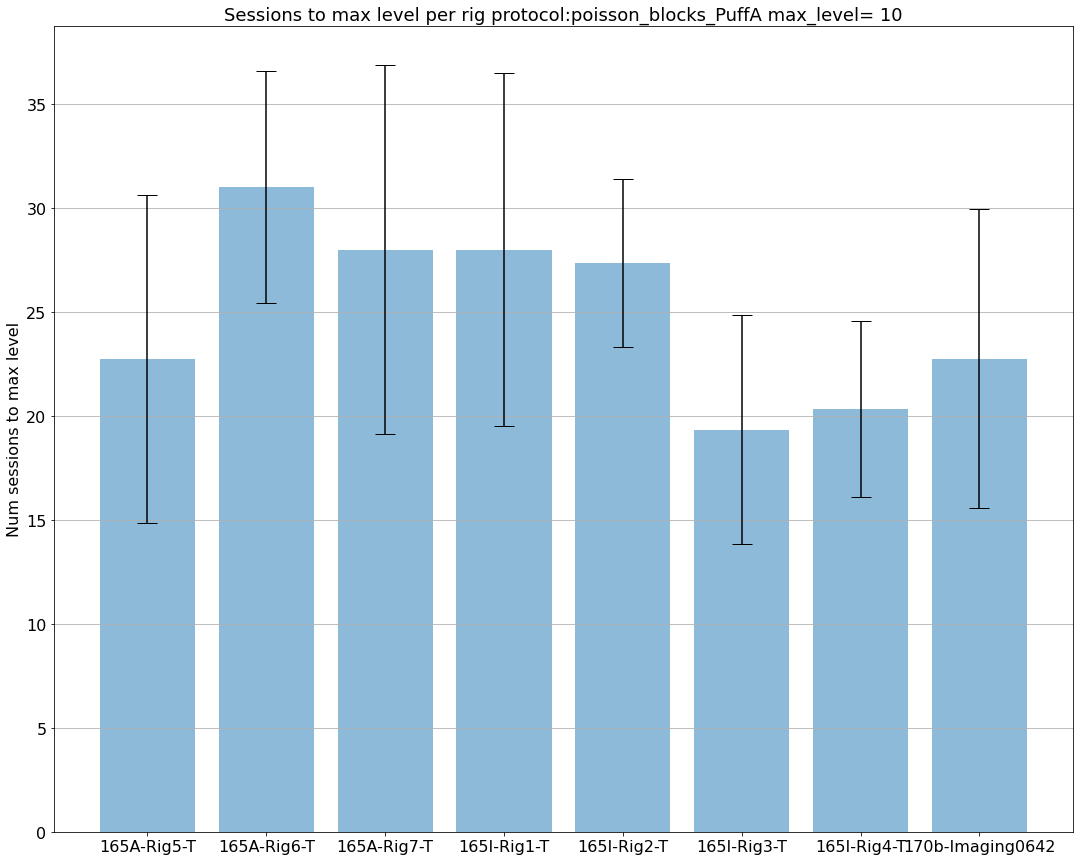

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(15,12))
x_pos = np.linspace(1, sessions_max_level_rig.shape[0], num=sessions_max_level_rig.shape[0])
ax.bar(x_pos, sessions_max_level_rig['mean_sessions'], yerr=sessions_max_level_rig['std_sessions'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Num sessions to max level', fontsize=16)
ax.set_xticks(x_pos)
ax.set_xticklabels(sessions_max_level_rig.index)
ax.set_title('Sessions to max level per rig protocol:' + protocol_df.index[0][0:20] + ' max_level= ' + str(max_level), fontsize=18)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [106]:
session_p_df

,subject_fullname,session_date,session_number,session_start_time,session_end_time,session_location,task,level,set_id,stimulus_bank,...,session_performance,num_trials,num_trials_try,session_narrative,session_protocol,session_code_version,is_bad_session,session_comments,seq_sessions,total_sessions
0,jounhong_CaMKIIa_tetO_23,2021-07-17,0,2021-07-17 08:00:00,2021-07-17 08:31:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,41.2698,63,[[63.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,1,14
1,jounhong_CaMKIIa_tetO_23,2021-07-18,0,2021-07-18 07:54:00,2021-07-18 08:40:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,54.2056,107,[[107.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,2,14
2,jounhong_CaMKIIa_tetO_23,2021-07-19,0,2021-07-19 11:02:00,2021-07-19 12:03:00,165A-Rig5-T,Towers,2,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,46.0396,202,[[202.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,3,14
3,jounhong_CaMKIIa_tetO_23,2021-07-20,0,2021-07-20 12:20:00,2021-07-20 13:21:00,165A-Rig5-T,Towers,4,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,83.0040,253,[[253.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,4,14
4,jounhong_CaMKIIa_tetO_23,2021-07-21,0,2021-07-21 13:06:00,2021-07-21 14:10:00,165A-Rig5-T,Towers,4,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,95.7265,234,[[234.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,sbolkan_d2_444,2021-04-11,0,2021-04-11 13:22:00,2021-04-11 14:28:00,165A-Rig5-T,Towers,11,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,68.7500,224,[[224.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,37,37
1639,sbolkan_test,2019-07-22,0,2019-07-22 16:19:00,2019-07-22 16:20:00,165I-Rig1-T,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,100.0000,2,[[2.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,1,4
1640,sbolkan_test,2020-01-27,0,2020-01-27 15:42:00,2020-01-27 15:50:00,165I-Rig2-T,Towers,1,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,50.0000,2,[[2.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,2,4
1641,sbolkan_test,2020-08-25,0,2020-08-25 10:15:00,2020-08-25 14:34:00,165I-Rig2-T,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,...,33.3333,3,[[3.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,,3,4
